In [1]:
import numpy as np
import re
import pandas as pd
import geopandas as gpd
import geodatasets

import random
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import poisson

from sklearn.metrics.pairwise import haversine_distances
from math import radians

#from plot_cities_route import plot_cities_route
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import IPython
from IPython.display import display, update_display

In [2]:
def plot_cities_route(df,x):
  # Load the Brazil map shapefile
  
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

  brazil = world[world['name'] == 'Brazil']
  fig, ax = plt.subplots(figsize=(4, 4))
  brazil.plot(ax=ax, color='lightgray')
  # df.plot(ax=ax, markersize=50, color='red', alpha=0.7)
  # Add labels to the points
  for lat, lng, label in zip(df.lat, df.lng, df['city']):
    ax.text(lng, lat, label, fontsize=8, ha='center', va='center')
    element = [0, 0]
    for k in range(1, len(x)+1):
      node_m = x[k-1]
      if k < len(x):
        node_n = x[k]
      else:
        node_n = x[0]

      lat = list(df.lat.iloc[[node_m,node_n]])
      lng = list(df.lng.iloc[[node_m,node_n]])
      if k==1:
        ax.plot(lng,lat,'-o',color='r')
      else:
        ax.plot(lng,lat,'-o',color='b')

In [3]:
def metropolis_hastings(x):
    movement_validity = False
    while not movement_validity:
        xp, rp = feasible_move(x)
        movement_validity = is_valid_move(r=0, rp=rp)
    return xp
# Generate feasible move
def feasible_move(x):
    unfeasability = True
    while unfeasability:
        rp = np.random.poisson(1)+1            # random permutation
        unfeasability = is_unfeasible(x, rp) # check feasability
    xp = random_permutation(x, rp)  # move to the new x
    return xp, rp

# Check if move is valid
def is_valid_move(r, rp):
    # (f(xt+1)/f(x))*q(xt|xt+1)/q(xt+1|xt)
    #alpha = poisson.pmf(rp-1, 1)/poisson.pmf(r-1, 1)
    alpha = 1
    return alpha > random.random()


def is_unfeasible(nodes, r=0):
    return r > (len(nodes)-1)/2


def random_permutation(nodes, r=1):
    pointer = [k+1 for k in range(len(nodes)-1)]
    rand_permutation = random.sample(pointer, 2*r) # original

    element = [0, 0]
    permute_list = []
    for k in range(len(rand_permutation)):
        if k % 2 == 0:
            element[0] = rand_permutation[k]
        elif k % 2 > 0:
            element[1] = rand_permutation[k]
            permute_list.append(element.copy())

    # Standardize permutation
    for k in range(len(permute_list)):
        element = permute_list[k].copy()
        if element[0] > element[1]:
            permute_list[k][0] = element[1]
            permute_list[k][1] = element[0]

    # permute
    for k in range(len(permute_list)):
        elements = permute_list[k]
        node_m = nodes[elements[0]]
        node_n = nodes[elements[1]]
        nodes[elements[0]] = node_n
        nodes[elements[1]] = node_m
    return nodes

In [4]:
# Read the CSV file
df = pd.read_csv('worldcities.csv', sep=',')
df = df.query("country=='Brazil' and (capital=='admin' or capital=='primary')")

def distance_matrix(latitude, longitude):
    lat_radians = [radians(coord) for coord in latitude]
    lng_radians = [radians(coord) for coord in longitude]

    lat_long = [lat_radians, lng_radians]
    lat_long = [list(k) for k in list(zip(*lat_long))]

    distance_matrix = haversine_distances(lat_long)
    distance_matrix = distance_matrix * (6371000/1000)
    return distance_matrix


distances = distance_matrix(latitude=list(df.loc[:, 'lat']),
                            longitude=list(df.loc[:, 'lng']))

def objective(path,distances):
    tour_distance = 0
    element = [0, 0]
    for k in range(1, len(path)+1):
        element[0] = path[k-1]
        if k < len(path):
            element[1] = path[k]
        else:
            element[1] = path[0]
        delta = distances[element[0], element[1]]
        tour_distance += delta
        #print(delta)
    return tour_distance

In [5]:
seed_number =3
T      = 1e6     # Start temperature
alpha  = 0.9     # Cooling Factor
L      = 100     # Steady-State Niters
stop_T = 1       # Stop temperature

In [6]:
#from IPython import display
#stop_T
#(T,T*alpha,T*(1+alpha))

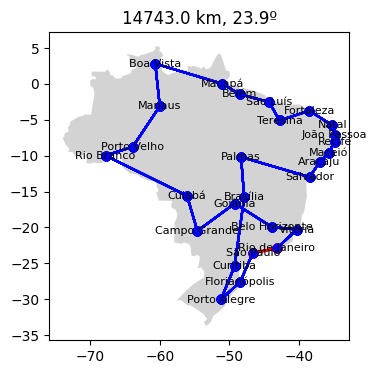

In [7]:
random.seed(seed_number)
np.random.seed(seed=seed_number)
filenames=[]
iter_data = []       # List to store iteration data
iter = 0

# Create a display object to update the output dynamically
output = display("", display_id=True)

while T >= stop_T:
  # Initialization
  if iter == 0:
    x0 = [k for k in range(len(df))]
    fs = objective(x0,distances)
    x = x0
    xbest = x.copy()
    fbest = fs.copy()
  for k in range(L):
    #print(f'simulated_anealing: {iter}')
    iter += 1
    # Generate a feasible movement (neighborhood generator)
    xp = metropolis_hastings(x.copy())  # neighborhood generator
    fsp = objective(xp,distances)
    dE = fsp - fs
    P  = expon.cdf(-dE/T)  # Probability of acceptance
    # Acceptance Criteria
    if dE< 0 or random.random() <  P:
      fs = fsp
      x = xp
      is_accepted= True
    else:
      is_accepted= False
      #armazena a solução ótima
    if (fs-fbest)< 0:
      xbest = x.copy()
      fbest = fs.copy()
      IPython.display.clear_output(wait=True)
      plot_cities_route(df, xbest)
      plt.title(f'''{np.round(fbest,0)} km, {np.round(T,1)}º''')
      fig = plt.gcf()
      plt.show()

      #filename = f'gifs\Traveling_salesman{iter}'
      #filenames.append(filename)
      #plt.savefig(filename, dpi=96, facecolor='white') 

    # Print the temperature dynamically
    output.update(IPython.display.HTML(f'''
    <p>iter: {iter}</p>
    <p>Temperature: {T}</p>
    <p>Distance: {fbest}</p>
    <p>Solution: {x}</p>
    '''))

    # Append iteration data to the list
    iter_data.append({
        '$iter$': iter,
        '$T$': T,
        '$\delta E$':dE,
        '$P$': P,
        '$x$': x,
        '$f_{s}$': fs,
        '$x_{opt}':xbest,
        '$f_{opt}':fbest,
        'is_accepted': is_accepted
        })
  # Update the temperature
  T = alpha * T

In [29]:
print('A solução encontrada foi: ')
for k in list(df.loc[:,'city'].iloc[xbest]):
  print(k)

A solução encontrada foi: 
São Paulo
Rio de Janeiro
Vitória
Belo Horizonte
Goiânia
Campo Grande
Cuiabá
Rio Branco
Porto Velho
Manaus
Boa Vista
Macapá
Belém
São Luís
Teresina
Fortaleza
Natal
João Pessoa
Recife
Maceió
Aracaju
Salvador
Palmas
Brasília
Curitiba
Porto Alegre
Florianópolis


In [11]:
iter_df = pd.DataFrame(iter_data)
iter_df = iter_df.query("is_accepted == True")
palette = sns.color_palette("rocket_r")

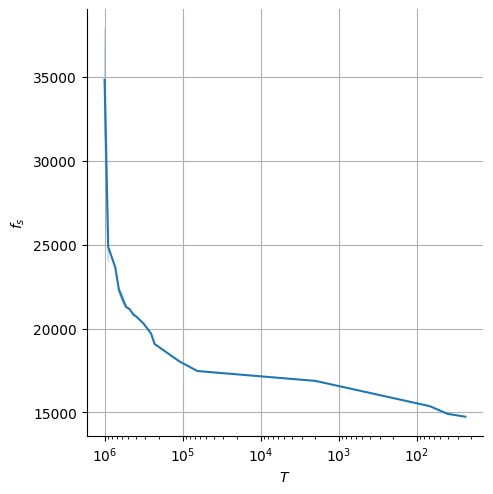

In [36]:
sns.relplot(x="$T$", y="$f_{s}$",kind="line",data=iter_df)
plt.gca().invert_xaxis()
plt.grid()
plt.xscale('log')

14743.3816695537


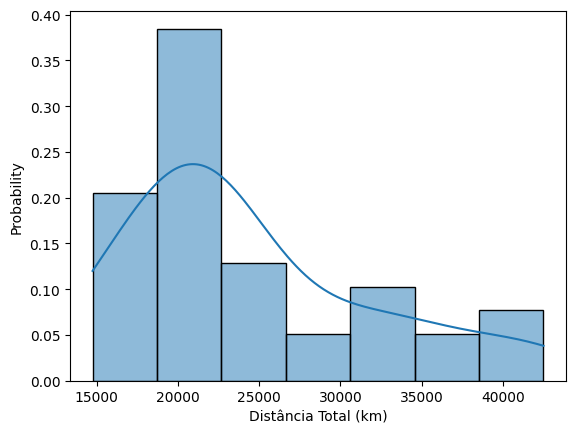

In [37]:
plt.figure()
sns.histplot(data=iter_df,x="$f_{s}$",stat="probability",kde=True)
plt.xlabel('Distância Total (km)')
print(fbest)
plt.show()